## Data
- We will be using NYC taxi data
- These have recently been changed to **parquet** files
- We will be using Pandas to read this data in via `pd.read_parquet()` command
    - This requires instaling PyArrow via `pip install pyarrow` on the VM
    - Also potentiall have to `pip install seaborn` and `pip install scikit-learn`
- In the `week1/` directory, run `mkdir data`, then `cd` into it 
- Download the Green January and February 2021 parquet data file via `wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet` and `wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet`

In [48]:
import os
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## 1. Load, inspect, and clean data

In [4]:
# read in the data parquet file
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

In [5]:
# inspect
df.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [6]:
# inspect
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [7]:
# create a trip duration column
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04


In [8]:
# convert duration to MINUTES
# - .total_seconds() is a timedelta function to return the total number of 
#       seconds covered for the specified duration of time instance
# https://docs.python.org/3/library/datetime.html#datetime.timedelta.total_seconds
# pandas.apply() this .total_seconds() function to every row in the DataFrame
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


C:\Users\nimz\AppData\Local\Temp\ipykernel_66428\1672738606.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration'])  # deprecated


<Axes: xlabel='duration', ylabel='Density'>

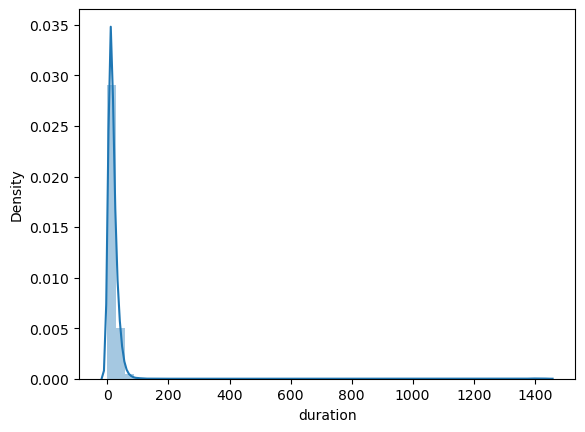

In [20]:
# inspect distribution of duration
sns.distplot(df['duration'])  # deprecated
# sns.displot(df['duration'])
# sns.histplot(df['duration'])

**Notice the long tail in our data is not making analyzing the data very helpful**

In [21]:
# inspect duration statistics
df['duration'].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [23]:
# inspect duration statistics
df['duration'].describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

**Can see that most of the data is within an hour (just a bit over 67 minutes), so it makes sense to only focus this majoruty of data**

In [24]:
# get data between 1 minute and 1 hour
df = df[(df.duration >= 1) & (df.duration <= 60)]

## 2. Prep for modeling

In [25]:
# define our variables/features
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [26]:
# convert our categorical variables/features to String
# THIS IF FOR ONE-HOT ENCODING via Dictionary Vectorizer
df[categorical] = df[categorical].astype(str)

# inspect (should be 'object' data type)
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [27]:
# create "records" by making dictionaries with keys and values of our features
# ***Each row of our DataFrame is turned into a dictionary***
train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts[:5]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45}]

In [53]:
# for feature extraction
# .DictVectorizer() = a transformer turns lists of mappings (dict-like objects) of feature names to 
#    feature values into Numpy arrays or scipy.sparse matrices for use with scikit-learn estimators
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html
dv = DictVectorizer()

In [29]:
# Learn a list of feature name -> indices mappings and transform X (input features)
X_train = dv.fit_transform(train_dicts)

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [31]:
# create out target and get its values for training
target = 'duration'
y_train = df[target].values

## 3. Linear regression model 1

In [35]:
# create a linear regression model object
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
lr = LinearRegression()

# fit it to our training data
lr.fit(X_train, y_train)

LinearRegression()

In [36]:
# make some predictions using our learned model
y_pred = lr.predict(X_train)

# check the mean squared error of our predictions
mean_squared_error(y_train, y_pred, squared=False)

9.827368941909368

C:\Users\nimz\AppData\Local\Temp\ipykernel_66428\3781675434.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')  # deprecated
C:\Users\nimz\AppData\Local\Temp\ipykernel_66428\3781675434.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')  # de

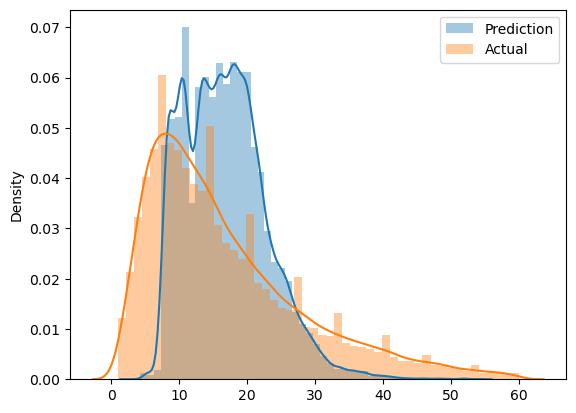

In [38]:
sns.distplot(y_pred, label='Prediction')  # deprecated
sns.distplot(y_train, label='Actual')  # deprecated

plt.legend()

**We can see that they differ pretty significantly, but we weren't expecting this model to be that good to begin with, especially with that error value that says our predictions are off by almost 10 minutes, on average**

## 4. Linear regression model 2 (with validation set)

In [39]:
# create helper function to read and clean data
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        
        # do some data conversion if CSV
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
        
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    
    # create duration in minutes column
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # filter to only trips between 1 minute and 1 hour
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    # specify categorical input features and convert to String
    # for one-hot encoding via Dictionary Vectorizer
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [40]:
# create DataFrames for training and validation
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

# see how many samples we have
len(df_train), len(df_val)

(73908, 61921)

In [41]:
# create a feature combining pickup and drop-off locations (feature engineering)
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [42]:
# specify our input features
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [43]:
# create training and validation input feature sets
dv = DictVectorizer()

# turn each row into dictionary and create the training set
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# turn each row into dictionary and create the validation set
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [44]:
# create training and validation label sets
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [45]:
# create and fit a model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [46]:
# make predictions using our learned model
y_pred = lr.predict(X_val)

# get the error
mean_squared_error(y_val, y_pred, squared=False)

7.758715208537182

**So, we got a little better, only off by about 8 minutes this time**

In [51]:
# Make the directory to hold the model file if it doesn't exist
os.makedirs(os.path.dirname('./models/lin_reg.bin'), exist_ok=True)

# save our dictionary vectorizer and our "best" model to deploy in the future
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## 5. Lasso regression model

In [52]:
# make a Lasso regression model
lr = Lasso(0.01)
lr.fit(X_train, y_train)

# make some predictions with the Lasso model
y_pred = lr.predict(X_val)

# get the error
mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

**Oddly enough, this is worse**

## 6. Ridge regression model (faster)

In [58]:
# make a Lasso regression model
lr = Ridge(alpha=1)
lr.fit(X_train, y_train)

# make some predictions with the Lasso model
y_pred = lr.predict(X_val)

# get the error
mean_squared_error(y_val, y_pred, squared=False)

7.7037351642480525

**So, we got a little better again**